In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the data 
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
# Make a dataframe
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Print out the dataframe
# display(test_df)

# Show the test data 
# display(train_df)

# Set how many rows are set in the dataframe
pd.set_option('display.min_rows', 10) 
pd.set_option('display.max_rows', 10) 

display(train_df)
print(train_df["Cabin"].isna().sum())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


687


In [3]:
import re 

pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 

new__train_df = train_df.copy(deep=True)
new__train_df['Title'] = new__train_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
# train_df

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}

def replace_cabin(x):
    x['Cabin'] = x['Cabin'].fillna("U0")
    x['Deck'] = x['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    x['Deck'] = x['Deck'].map(deck)
    x['Deck'] = x['Deck'].fillna("U")
    x.drop('Cabin',axis=1, inplace=True)
    
    return x


new__train_df['Title']=new__train_df.apply(replace_titles, axis=1)
new__train_df= replace_cabin(new__train_df)


new__train_df
print(new__train_df["Deck"].isna().sum())

0


In [4]:
# Import the methods for pipeline processing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Function to take a dataframe and prepare it for training. It imputes (fills missing values) for"Age" and "Fare", 
# makes the "Cabin" and "Sex" column binary (i.e in a cabin or not, male or female) and one hot encodes the "Embarked" column. 
def prepare_dataframe(df, drop_columns):
    # Copying dataframe to manipulate
    new_df = df.copy(deep=True)
    
    # new_df["Cabin"] = new_df["Cabin"].notnull().astype('int')
    
    binary_mapping = {"male" : 0, "female": 1}
    new_df["Sex"] = new_df["Sex"].map(binary_mapping)
    
    new_df['Title'] = new_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
    new_df['Title'] = new_df.apply(replace_titles, axis=1)
    
    new_df= replace_cabin(new_df)
    
    numeric_features = ["Age", "Fare"]
    categorical_features = ["Embarked", "Title", "Deck"]
    
    numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy="mean"))])
    
    categorical_transformer = Pipeline(steps = [ ("imputer", SimpleImputer(strategy = "constant", 
                                                                           fill_value="missing")),
                                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),
                                                    ("cat", categorical_transformer, categorical_features)])
    
    preprocessor.fit(new_df)
    
    transformed_data = preprocessor.transform(new_df)
         
    numeric_data = transformed_data[:, :len(numeric_features)].toarray()
    categorical_data = transformed_data[:, len(numeric_features):].toarray()
        
    categorical_encoded_features = preprocessor.named_transformers_['cat']['onehot'] \
                                    .get_feature_names_out(input_features=categorical_features)
    
    # Replace the columns with transformed data
    new_df[categorical_encoded_features] = categorical_data
    new_df[numeric_features] = numeric_data
    
    # Emabarked missing removed for the training set as it has a null value 
    if "Embarked_missing" in new_df.columns:
        new_df.drop("Embarked_missing", axis=1, inplace=True)
    if "Title" in new_df.columns:
        new_df.drop("Title", axis=1, inplace=True)
    if "Deck" in new_df.columns:
        new_df.drop("Deck", axis=1, inplace=True)
    
    new_df.drop(drop_columns,axis =1, inplace=True)
    
    return pd.DataFrame(new_df)

In [5]:
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]
#display(train_df)
new_train_df = prepare_dataframe(train_df, drop_columns)
display(new_train_df)
new_train_df.columns

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,...,Title_Mr,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,0,3,0,22.000000,1,0,7.2500,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,3,1,26.000000,0,0,7.9250,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,3,0,35.000000,0,0,8.0500,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,3,0,29.699118,0,0,8.4583,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,1,0,54.000000,0,0,51.8625,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0,3,0,2.000000,3,1,21.0750,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1,3,1,27.000000,0,2,11.1333,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1,2,1,14.000000,1,0,30.0708,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U'],
      dtype='object')

0
177
0
1


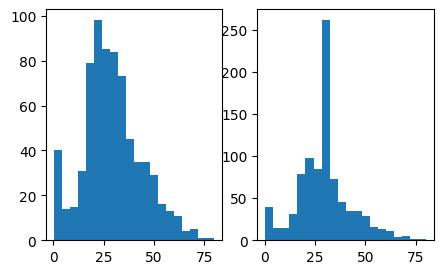

In [6]:
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

#Plotting histograms of the feature variables
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize = (5,3))

#print(len(train_df["Age"]), len(train_df_missing["Age"]))

ax[0].hist(train_df["Age"], bins=20);

ax[1].hist(new_train_df["Age"], bins=20);

print(new_train_df["Age"].isna().sum())
print(train_df["Age"].isna().sum())

print(new_test_df["Fare"].isna().sum())
print(test_df["Fare"].isna().sum())

In [7]:
# Quick fitting of the data
from sklearn.metrics import accuracy_score

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

# First RandomForestClassifier 

# Setup the random seed
np.random.seed(42)

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = new_test_df
display(x_train)

# Import randomforestclassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# display(x_train)
# display(x_test)
# display(new_test_df)
y_preds = clf.predict(x_train)

print(accuracy_score(y_preds, y_train))

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Title_Master,...,Title_Mr,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,3,0,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1,26.000000,0,0,7.9250,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3,0,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,3,0,29.699118,0,0,8.4583,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,1,0,54.000000,0,0,51.8625,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,3,0,2.000000,3,1,21.0750,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,3,1,27.000000,0,2,11.1333,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2,1,14.000000,1,0,30.0708,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


0.9865319865319865


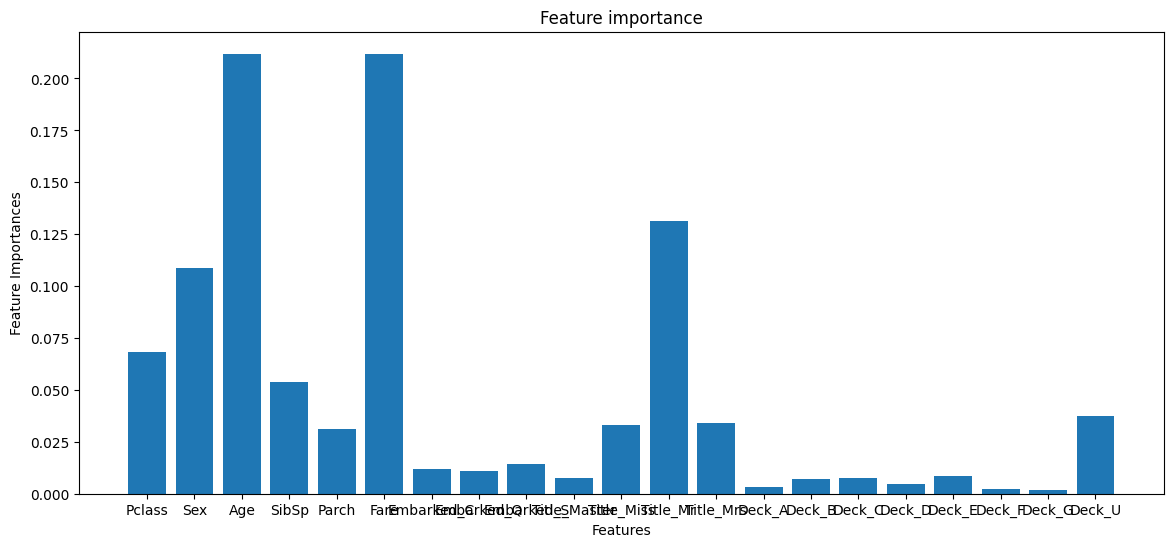

In [8]:
# Gives the importance of different features of the model
importance = clf.feature_importances_

importance_dictionary = {x_train.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(14, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [9]:
from sklearn.base import clone
np.random.seed(42)


# Random Forest model, not including all the features below

drop_columns_cabin = ["Embarked", "Ticket", "Name", "PassengerId", 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U']

from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}
 

# Setup the random seed
np.random.seed(42)

x_train_cabin = prepare_dataframe(train_df, drop_columns_cabin).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_cabin = prepare_dataframe(test_df, drop_columns_cabin)

clf = RandomForestClassifier(n_jobs = 1)

rs_clf = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )

rs_clf.fit(x_train_cabin, y_train);
best_params_cabin = rs_clf.best_params_
cv_results_cabin = rs_clf.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.317770,0.026472,0.047654,0.000288,500,10,1,sqrt,10,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.793296,0.803371,0.876404,0.808989,0.853933,0.827199,0.032201,5
1,1.114686,0.010814,0.050847,0.000853,500,2,2,sqrt,None,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.798883,0.803371,0.859551,0.792135,0.831461,0.817080,0.025107,8
2,0.234178,0.001368,0.012879,0.000142,100,5,1,sqrt,40,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.770950,0.792135,0.837079,0.792135,0.831461,0.804752,0.025375,10
3,2.637207,0.017389,0.094662,0.001641,1000,5,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.810056,0.808989,0.865169,0.803371,0.859551,0.829427,0.027044,3
4,1.099871,0.030195,0.050162,0.001924,500,2,1,sqrt,10,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.798883,0.797753,0.831461,0.797753,0.859551,0.817080,0.024855,8
5,1.324422,0.005519,0.049047,0.000529,500,10,1,sqrt,None,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.798883,0.797753,0.870787,0.808989,0.853933,0.826069,0.030360,6
6,2.610002,0.022429,0.093206,0.002357,1000,10,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 10...",0.798883,0.808989,0.882022,0.803371,0.853933,0.829439,0.032852,2
7,0.215914,0.002360,0.012384,0.000326,100,5,4,sqrt,None,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.804469,0.803371,0.876404,0.814607,0.853933,0.830557,0.029402,1
8,1.345219,0.015289,0.050267,0.000933,500,5,1,sqrt,20,True,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.815642,0.803371,0.876404,0.797753,0.853933,0.829421,0.030593,4
9,4.258878,0.018800,0.186007,0.001483,2000,2,2,sqrt,10,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.793296,0.797753,0.859551,0.808989,0.859551,0.823828,0.029613,7


0.8234850291883749


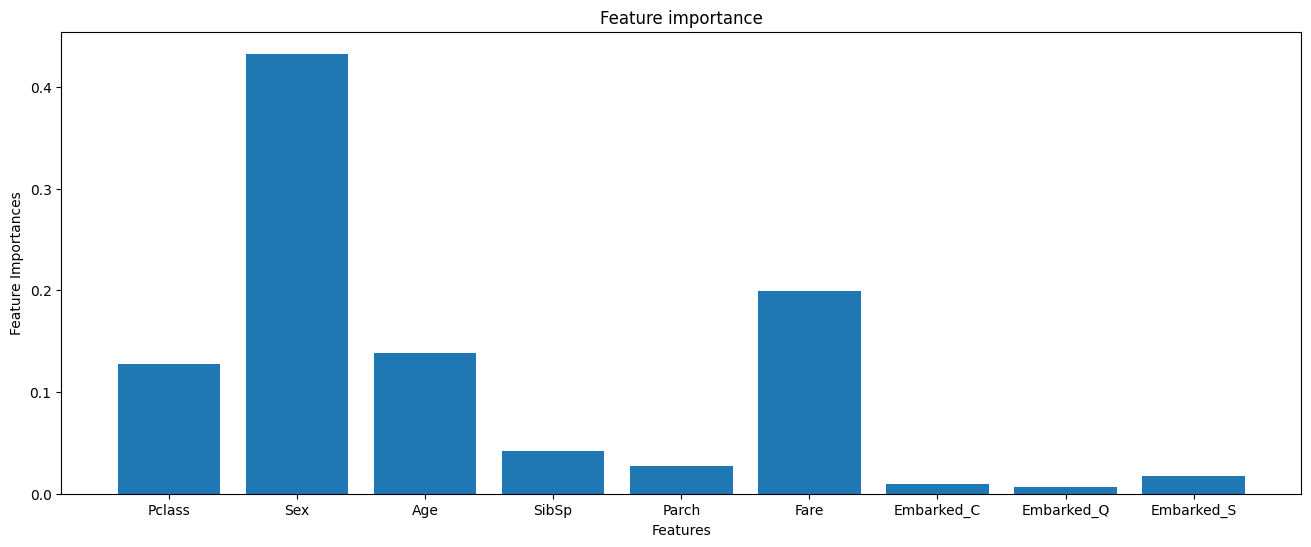

In [10]:
pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 

print(best_params_cabin)
cv_results_cabin_df = pd.DataFrame(cv_results_cabin)
display(cv_results_cabin_df)

print(cv_results_cabin_df["mean_test_score"].mean())

importance = rs_clf.best_estimator_.feature_importances_

importance_dictionary = {x_train_cabin.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(16, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [11]:
from sklearn.base import clone
np.random.seed(42)


# Random forest model not including all the features below

drop_columns_titles = ["Embarked", "Ticket", "Name", "PassengerId", 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', \
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U']

from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}
 

# Setup the random seed
np.random.seed(42)

x_train_titles = prepare_dataframe(train_df, drop_columns_titles).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_titles = prepare_dataframe(test_df, drop_columns_titles)

clf = RandomForestClassifier(n_jobs = 1)

rs_clf_titles = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )

rs_clf_titles.fit(x_train_titles, y_train);
best_params_titles = rs_clf_titles.best_params_
cv_results_titles = rs_clf_titles.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=

{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.293487,0.012280,0.047932,0.000299,500,10,1,sqrt,10,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.832402,0.786517,0.859551,0.803371,0.859551,0.828278,0.029453,3
1,1.084938,0.006624,0.053833,0.005347,500,2,2,sqrt,None,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.821229,0.792135,0.870787,0.775281,0.831461,0.818178,0.033081,9
2,0.225373,0.002743,0.012893,0.000077,100,5,1,sqrt,40,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.798883,0.797753,0.853933,0.780899,0.825843,0.811462,0.025655,10
3,2.596080,0.020245,0.093663,0.001072,1000,5,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.810056,0.797753,0.870787,0.803371,0.848315,0.826056,0.028524,5
4,1.050747,0.005966,0.049086,0.000294,500,2,1,sqrt,10,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.821229,0.797753,0.865169,0.797753,0.842697,0.824920,0.026175,7
5,1.309905,0.014975,0.049787,0.000764,500,10,1,sqrt,None,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.826816,0.786517,0.870787,0.803371,0.859551,0.829408,0.032078,2
6,2.591672,0.033666,0.093356,0.002143,1000,10,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 10...",0.821229,0.803371,0.859551,0.803371,0.859551,0.829414,0.025456,1
7,0.210797,0.002706,0.012698,0.000790,100,5,4,sqrt,None,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.810056,0.780899,0.876404,0.808989,0.859551,0.827180,0.035319,4
8,1.336344,0.015206,0.050017,0.000564,500,5,1,sqrt,20,True,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.810056,0.797753,0.859551,0.797753,0.848315,0.822685,0.026148,8
9,4.135011,0.033484,0.185844,0.001605,2000,2,2,sqrt,10,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.821229,0.786517,0.870787,0.803371,0.848315,0.826044,0.030323,6


0.8243625635553326


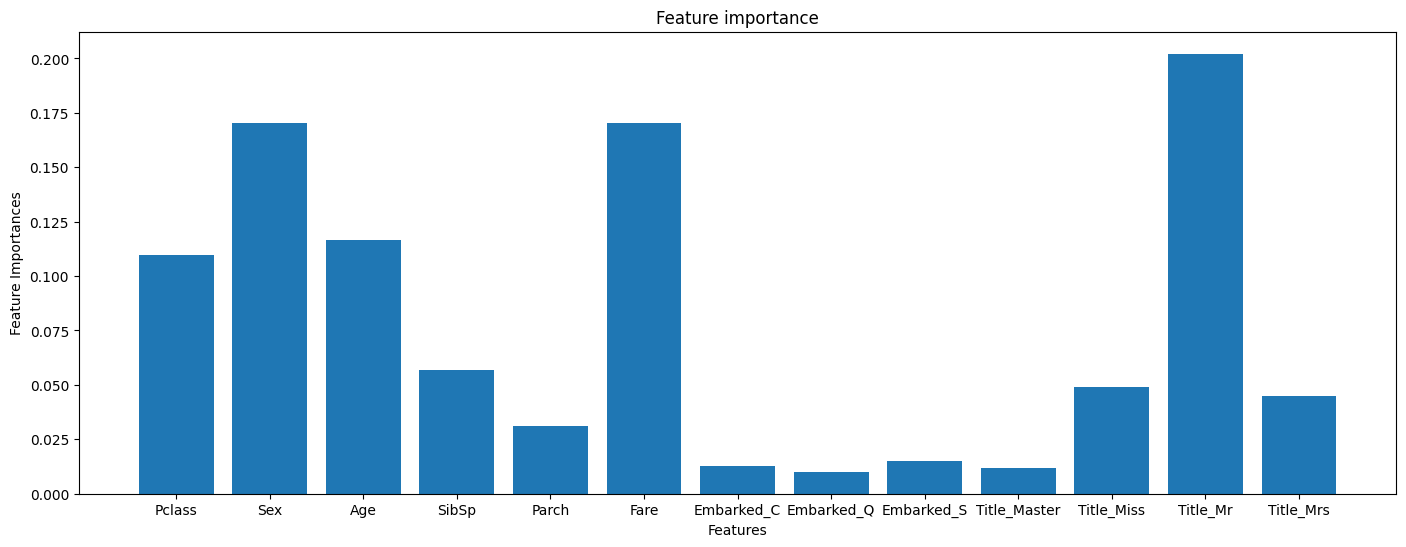

In [12]:
pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 

print(best_params_titles)
cv_results_titles_df = pd.DataFrame(cv_results_titles)
display(cv_results_titles_df)

print(cv_results_titles_df["mean_test_score"].mean())

importance = rs_clf_titles.best_estimator_.feature_importances_

importance_dictionary = {x_train_titles.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(17, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [13]:
from sklearn.base import clone
np.random.seed(42)


# Random forest model not including 

drop_columns_decks = ["Embarked", "Ticket", "Name", "PassengerId"]

from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}
 

# Setup the random seed
np.random.seed(42)

x_train_decks = prepare_dataframe(train_df, drop_columns_decks).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_decks = prepare_dataframe(test_df, drop_columns_decks)

clf = RandomForestClassifier(n_jobs = 1)

rs_clf_decks = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )

rs_clf_decks.fit(x_train_decks, y_train);
best_params_decks = rs_clf_decks.best_params_
cv_results_decks = rs_clf_decks.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.286701,0.010109,0.048128,0.000502,500,10,1,sqrt,10,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.826816,0.786517,0.848315,0.808989,0.853933,0.824914,0.024985,8
1,1.079417,0.016241,0.050909,0.000985,500,2,2,sqrt,None,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.860335,0.786517,0.853933,0.797753,0.837079,0.827123,0.029774,6
2,0.228023,0.001656,0.013728,0.000358,100,5,1,sqrt,40,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.810056,0.775281,0.831461,0.775281,0.831461,0.804708,0.025266,10
3,2.619326,0.012415,0.094266,0.001356,1000,5,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.843575,0.808989,0.853933,0.797753,0.853933,0.831636,0.023655,2
4,1.064274,0.013165,0.050393,0.001183,500,2,1,sqrt,10,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.843575,0.803371,0.853933,0.780899,0.848315,0.826018,0.028752,7
5,1.323796,0.007810,0.049795,0.000815,500,10,1,sqrt,None,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.837989,0.792135,0.865169,0.803371,0.853933,0.830519,0.028337,3
6,2.598177,0.026025,0.093869,0.002126,1000,10,1,sqrt,10,True,"{'n_estimators': 1000, 'min_samples_split': 10...",0.826816,0.792135,0.859551,0.808989,0.848315,0.827161,0.024713,5
7,0.207344,0.002339,0.013014,0.000448,100,5,4,sqrt,None,False,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.843575,0.797753,0.859551,0.808989,0.859551,0.833884,0.025833,1
8,1.353147,0.013005,0.051265,0.000639,500,5,1,sqrt,20,True,"{'n_estimators': 500, 'min_samples_split': 5, ...",0.837989,0.792135,0.842697,0.792135,0.848315,0.822654,0.025132,9
9,4.109879,0.037304,0.186523,0.004279,2000,2,2,sqrt,10,False,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.843575,0.792135,0.853933,0.808989,0.848315,0.829389,0.024355,4


0.8258006402611262


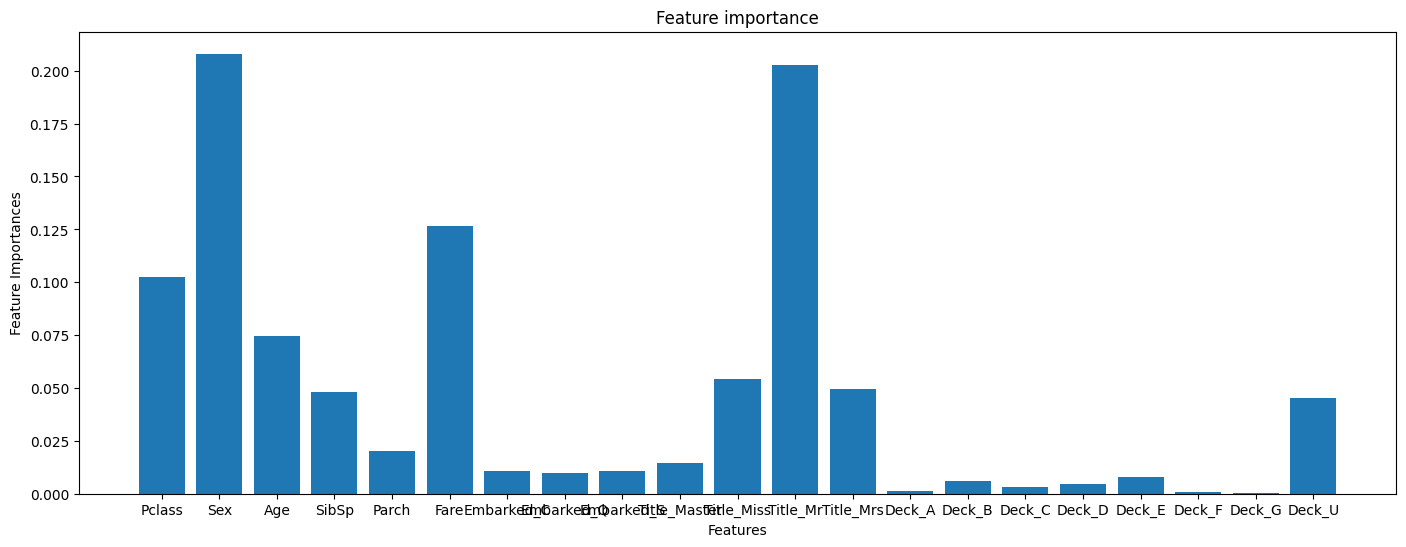

In [14]:
pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 

print(best_params_decks)
cv_results_decks_df = pd.DataFrame(cv_results_decks)
display(cv_results_decks_df)

print(cv_results_decks_df["mean_test_score"].mean())

importance = rs_clf_decks.best_estimator_.feature_importances_

importance_dictionary = {x_train_decks.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(17, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

712 891
179 179
0.8547486033519553
0.8212290502793296


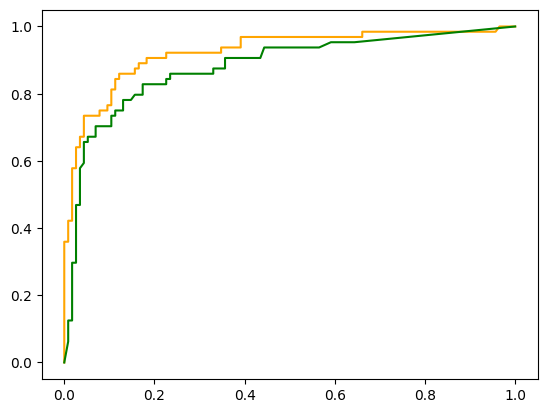

In [15]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve

np.random.seed(42)

# Function to divide a dataframe into validation and training sets with cross validation (k-folds). Returns the desired fold  
def cross_val_index(k_folds, x_dataframe, y_dataframe, fold_number):
    index = round(len(x_dataframe)/k_folds)
    start_index, end_index = [], []
    for i in range(k_folds):
                start_index.append(i * index)
                end_index.append((i + 1) * index if i < k_folds - 1 else len(x_dataframe))
    print(start_index[fold_number-1], end_index[fold_number-1])
    X_train = pd.concat([x_dataframe[:start_index[fold_number-1]], x_dataframe[end_index[fold_number-1]:]])
    y_train = pd.concat([y_dataframe[:start_index[fold_number-1]], y_dataframe[end_index[fold_number-1]:]])
    X_valid = x_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    y_valid = y_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    print(len(X_valid), len(y_valid))
    
    return X_train, y_train, X_valid, y_valid



drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

# Setting up validation dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]


cross_val_dataframes = cross_val_index(5, x_train, y_train, 5)


best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
best_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
best_y_valid_preds = best_clf.predict(cross_val_dataframes[2])
best_y_valids_proba = best_clf.predict_proba(cross_val_dataframes[2])
best_y_valids_proba_pos = best_y_valids_proba[:, 1]
print(accuracy_score(best_y_valid_preds, cross_val_dataframes[3]))

worst_clf = RandomForestClassifier( **{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
worst_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
worst_y_valid_preds = worst_clf.predict(cross_val_dataframes[2])
worst_y_valids_proba = worst_clf.predict_proba(cross_val_dataframes[2])
worst_y_valids_proba_pos = worst_y_valids_proba[:, 1]
print(accuracy_score(worst_y_valid_preds, cross_val_dataframes[3]))

best_fpr, best_tpr, best_thresholds = roc_curve(cross_val_dataframes[3].values, best_y_valids_proba_pos)
worst_fpr, worst_tpr, worst_thresholds = roc_curve(cross_val_dataframes[3].values, worst_y_valids_proba_pos)




plt.plot(best_fpr, best_tpr, color='orange', label='ROC')
plt.plot(worst_fpr, worst_tpr, color='green', label='ROC')



In [16]:
drop_columns_embarked = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin", "Embarked_C", "Embarked_Q", "Embarked_S"]
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)

best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
best_clf.fit(x_train, y_train)
best_y_preds = best_clf.predict(x_test)

clf.fit(x_train, y_train)
best_y_preds = clf.predict(x_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': best_y_preds})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         1
4            896         1
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
..           ...       ...
408         1300         0
409         1301         1
410         1302         0
411         1303         1
412         1304         0
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!


In [17]:
# Quick fitting of the data

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

# First RandomForestClassifier 

# Setup the random seed
np.random.seed(42)

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = new_test_df

# Import randomforestclassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Instantiate the classifier
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(x_train, y_train)

# display(x_train)
# display(x_test)
# display(new_test_df)
y_preds = clf.predict(x_train)

print(accuracy_score(y_preds, y_train))

0.9865319865319865


In [18]:
log_y_preds = log_clf.predict(x_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': log_y_preds})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
..           ...       ...
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         1
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!
